## Module Imports

In [1]:
include("emulation_functions.jl")
using BenchmarkTools
using CSV
using JLD2
using Dates
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using NCDatasets
using DataFrames
using ForwardDiff
using LinearAlgebra
using NamedArrays
using Plots
using Plots.PlotMeasures
using Optimization
using OptimizationOptimJL
using Statistics
using StatsPlots
using Distributions
using Turing
#using Random
using .Threads

## Set File Directory
Set the `directory_of_files` variable below to the path leading to your folder containing all the data and emulator files.

In [3]:
# directory where all files are located. If it is this working directory, set this to "./"
directory_of_files = "../data/"; 
p_names = (:flnr,:slatop,:dleaf,:dsladlai,:leaf_long,:s_vc,:bbbopt,:mbbopt,:smpsc,:smpso,:rholvis,:rholnir,:taulvis,:taulnir,:rhosvis,:rhosnir,:xl,:displar,:z0mr,:vcmaxha,:vcmaxhd,:jmaxha,:jmaxhd,:roota_par,:rootb_par,:grperc)
p_names_dis = (:flnr,:slatop,:leaf_long, :rootb_par)

D = length(p_names_dis)

4

## Load data 

In [5]:
# Dictionaries to make this all neater
output_var_header_names = Dict{String, String}("GPP" => "GPP_NT_VUT_REF", 
                                               "NEE" => "NEE_VUT_REF", 
                                               "LH" => "LE_F_MDS", 
                                               "SH" => "H_F_MDS")
site_names = Dict{String, String}("US_Me2" => "fluxnet_US_Me2_2003_2007", 
                                  "US_Dk3" => "fluxnet_US_Dk3_2003_2007",
                                  "CA_TP4" => "fluxnet_CA_TP4_2003_2007",
                                  "US_Blo" => "fluxnet_US_Blo_2003_2007",
    );

## Load default parameters

In [7]:
p_default=[0.0509,0.01,0.04,0.0006,1.5,20.72,10000,9,-255000,-66000,0.07,0.35,0.05,0.1,0.16,0.39,0.01,0.67,0.055,72000,200000,50000,200000,3,1.25,0.3]
elements = ["flnr","slatop","dleaf","dsladlai","leaf_long","s_vc","bbbopt","mbbopt","smpsc","smpso","rholvis","rholnir","taulvis",
            "taulnir","rhosvis","rhosnir","xl","displar","z0mr","vcmaxha","vcmaxhd","jmaxha","jmaxhd","roota_par","rootb_par","grperc"]
elements_4par = ["flnr","slatop","leaf_long","rootb_par"]
p_hard = (  flnr =      [0.04, 0.3],                         
            slatop =    [0.003, 0.03],
            dleaf =     [0.03, 0.3],
            dsladlai =  [0.0002, 0.0035],
            leaf_long = [1.0, 12.0],
            s_vc =      [16.0,32.0],
            bbbopt =    [16000.0,60000.0],
            mbbopt =    [4.5, 15],
            smpsc =     [-642000.0, -125000.0],
            smpso =     [-125000.0, -17500.0],
            rholvis =   [0.025, 0.25],
            rholnir =   [0.25,0.55],
            taulvis =   [0.005,0.20],
            taulnir =   [0.15,0.45],
            rhosvis =   [0.05,0.30],
            rhosnir =   [0.20,0.75],
            xl =        [-0.5,0.375],
            displar =   [0.6,0.85],
            z0mr =      [0.04,0.09],
            vcmaxha =   [45000.0,90000.0],
            vcmaxhd =   [198000.0, 202000.0],
            jmaxha =    [30000.0,65000.0],
            jmaxhd =    [198000.0, 202000.0],
            roota_par = [2.0,18.0],
            rootb_par = [0.5,6.0],
            grperc =    [0.125,0.375] );

p_hard = [getproperty(p_hard, pn) for pn in propertynames(p_hard)];
p_hard_l = mapreduce(permutedims, vcat, p_hard)[:, 1];
p_hard_u = mapreduce(permutedims, vcat, p_hard)[:, 2];
p_norm = (p_default.- p_hard_l) ./ (p_hard_u .- p_hard_l)

26-element Vector{Float64}:
  0.041923076923076924
  0.25925925925925924
  0.03703703703703704
  0.1212121212121212
  0.045454545454545456
  0.29499999999999993
 -0.13636363636363635
  0.42857142857142855
  0.7485493230174082
  0.5488372093023256
  0.2
  0.3333333333333332
  0.23076923076923078
 -0.1666666666666666
  0.44
  0.3454545454545454
  0.5828571428571429
  0.28000000000000025
  0.3
  0.6
  0.5
  0.5714285714285714
  0.5
  0.0625
  0.13636363636363635
  0.7

## NOTE: 
#### `output_of_interest`
+ "GPP"
+ "NEE"
+ "LE"
+ "H"


In [9]:
# == SPECIFY THESE PARAMETERS TO SELECT OUTPUT VAR, SITE EMULATOR, AND CALIBRATION SITE OF INTEREST ===
c_site1_to_calibrate_to = "US_Me2"
c_site2_to_calibrate_to = "US_Dk3"
c_site3_to_calibrate_to = "US_Blo"
c_site4_to_calibrate_to = "CA_TP4"
c_site5_to_calibrate_to = "US_NR1"

output_of_interest = "GPP"


"GPP"

In [10]:
#site =  site_names[site_to_calibrate_to]
output = output_var_header_names[output_of_interest]
begin_date = "2003" # Begin date of fluxnet data file (in case this changes in the future)
end_date = "2007" # End data of fluxnet data file (in case this changes in the future)

"2007"

In [11]:
function calculate_10day_average(data0)

    num_years = 5  
    monthday=[10, 10,11,10,10,8,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11];
    monthly_average = Vector{Float64}()
    end_day=0
    for year in 1:num_years
        start_day=end_day+1
        for month in 1:36
            end_day = start_day + monthday[month]-1
            temp=mean(filter(!isnan,data0[start_day:end_day,:]), dims=1)
            push!(monthly_average,temp[1])
            start_day=end_day+1
        end
    end

    return monthly_average 
end

calculate_10day_average (generic function with 1 method)

In [12]:
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_GPP = Array(data[!, "GPP_NT_VUT_REF"])
id_1=findall(y_site1_GPP.<0)
y_site1_GPP[id_1].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_NEE = Array(data[!, "NEE_VUT_REF"])
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_FSH = Array(data[!, "H_F_MDS"])
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_LH = Array(data[!, "LE_F_MDS"]);



In [13]:
GPP_01 = calculate_10day_average(y_site1_GPP)
NEE_01 = calculate_10day_average(y_site1_NEE)
FSH_01 = calculate_10day_average(y_site1_FSH)
LH_01 = calculate_10day_average(y_site1_LH)

Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
 12.382442999999999
  9.210005
 22.432102727272728
 11.999566999999999
 18.717375
 22.1399
 27.24223
 34.53917
 39.72402727272728
 29.98108
 40.022459999999995
 34.43771
 34.63343
  ⋮
 22.72415
 19.717852
 21.755969999999998
 30.007879999999993
 32.15707
 28.799963636363643
 30.05639
 35.535591999999994
 38.36195
 11.491902
 22.019117
 31.105345454545454

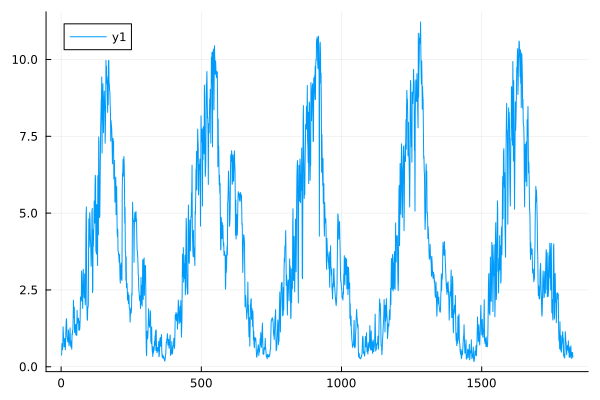

In [14]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_GPP_200_4par.txt", DataFrame; header = false, transpose=true);
GPP1 = Matrix(ensembles0)'*24*3600
ensembles_mGPP1 = mean(GPP1, dims=1)
GPP_Me2_be_200=GPP1[:,200]
plot(GPP_Me2_be_200)

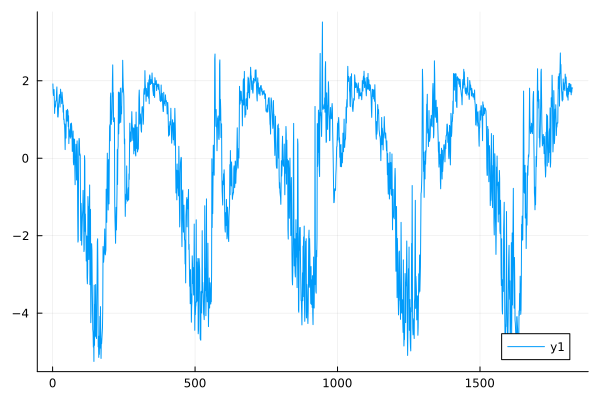

In [15]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_NEE_200_4par.txt", DataFrame; header = false, transpose=true);
NEE1 = Matrix(ensembles0)'*24*3600
ensembles_mNEE1 = mean(NEE1, dims=1)
NEE_Me2_be_200=NEE1[:,200]
plot(NEE_Me2_be_200)


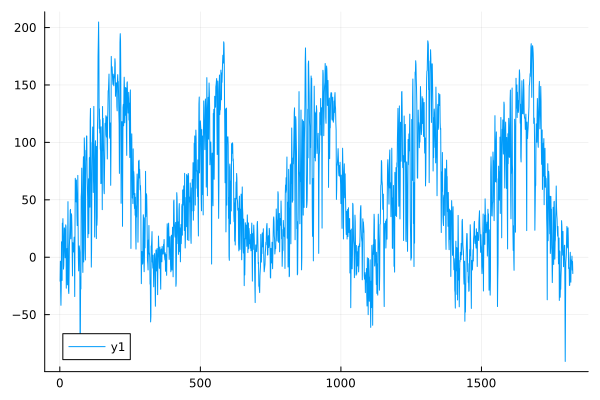

In [16]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_FSH_200_4par.txt", DataFrame; header = false, transpose=true);
FSH1 = Matrix(ensembles0)'
ensembles_mFSH1 = mean(FSH1, dims=1)
FSH_Me2_be_200=FSH1[:,200]
plot(FSH_Me2_be_200)

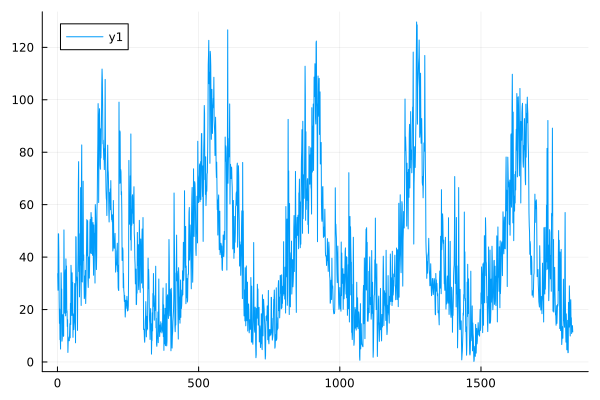

In [17]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_LH_200_4par.txt", DataFrame; header = false, transpose=true);
LH1 = Matrix(ensembles0)'
ensembles_mLH1 = mean(LH1, dims=1)
LH_Me2_be_200=LH1[:,200]
plot(LH_Me2_be_200)

In [18]:
GPP_01_be_ens=calculate_10day_average(GPP_Me2_be_200)
NEE_01_be_ens=calculate_10day_average(NEE_Me2_be_200)
FSH_01_be_ens=calculate_10day_average(FSH_Me2_be_200)
LH_01_be_ens=calculate_10day_average(LH_Me2_be_200)

a1=std(y_site1_GPP-GPP_Me2_be_200)
iid_normal_noise1 = a1*randn(1825)
GPP_01_be=calculate_10day_average(GPP_Me2_be_200+iid_normal_noise1)
a2=std(y_site1_NEE-NEE_Me2_be_200)
iid_normal_noise2 = a2*randn(1825)
NEE_01_be=calculate_10day_average(NEE_Me2_be_200+iid_normal_noise2)
a3=std(y_site1_FSH-FSH_Me2_be_200)
iid_normal_noise3 = a3*randn(1825)
FSH_01_be=calculate_10day_average(FSH_Me2_be_200+iid_normal_noise3)
a4=std(y_site1_LH-LH_Me2_be_200)
iid_normal_noise4 = a4*randn(1825)
LH_01_be=calculate_10day_average(LH_Me2_be_200+iid_normal_noise4)
println([a1,a2,a3,a4])

Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
[1.4548565509669047, 1.7645725125484282, 39.56049223900845, 18.491182437605808]


## Load emulator (all GPs used in reconstruction)

In [20]:
emulator_filename1 = "./emulator_GPP_US_Me2_200_4par.jld2";
@load emulator_filename1 array_GP pca_fit μ_z σ_z
emulator_components1 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename2 = "./emulator_NEE_US_Me2_200_4par.jld2";
@load emulator_filename2 array_GP pca_fit μ_z σ_z
emulator_components2 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename3 = "./emulator_FSH_US_Me2_200_4par.jld2";
@load emulator_filename3 array_GP pca_fit μ_z σ_z
emulator_components3 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename4 = "./emulator_LH_US_Me2_200_4par.jld2";
@load emulator_filename4 array_GP pca_fit μ_z σ_z
emulator_components4 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);

┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64

## Bayesian Parameter Calibration

## Create probabilistic model

Our likelihood looks like linear regression and features discrepency terms $\beta_0$ and $\beta_1$ in addition to noise term $\epsilon$.

### Likelihood: 
$$y \sim \beta_1 GP(\theta) + \epsilon, \qquad $$
$$\epsilon \stackrel{iid}{\sim} N(0,\sigma^2)$$

for now we assume a known $\sigma$, but we could estimate this parameter as well. $y$ is any quantity of interest predicted by the GP, $\theta$ are the model parameters (from the ELM model, the set of 26 params)

### Priors: 

$$\theta \sim p(\theta)$$ 
$$p(\theta) = Normal(0.5,0.25)$$
$$\log(\sigma) \sim N(\log 1, ((\log 2)/2)^2)$$

And I chose Normal priors for the regression parameters and LogNormal for the standard deviation. 


Define Prior distributions

ZJ: I change the priors and define the prob_model for each site, as the emulators are different

### Qoi 1

In [21]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_1(θ,N_PCA)= calibration_emulator1(θ, emulator_components1, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [22]:
@model function prob_model_1(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_1(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_1 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample=5000
N_chain = 5
model = prob_model_1(GPP_01_be, N_param, 12)
@time chain1 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain1 = replacenames(chain1, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_GPP_be_a1_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain1

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain1 = Array{Any}(undef, 5);
model = prob_model_1(GPP_01_be, N_param, 12)
for n=1:5
iid_normal_noise1 = a1*randn(1825)
GPP_01_be=calculate_10day_average(GPP_Me2_be_200+iid_normal_noise1)
@time chain1[n] = Turing.sample(prob_model_1(GPP_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain1[n]  = replacenames(chain1[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_GPP_be_a1_diff_iid_nobeta0_5000_5_4par_180day_4var_1_samebe200.jld2" chain1

### Qoi 2

In [40]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_2(θ,N_PCA)= calibration_emulator1(θ, emulator_components2, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [42]:
@model function prob_model_2(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_2(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_2 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain2 = Array{Any}(undef, 5);
for n=1:5
iid_normal_noise2 = a2*randn(1825)
NEE_01_be=calculate_10day_average(NEE_Me2_be_200+iid_normal_noise2)
@time chain2[n] = Turing.sample(prob_model_2(NEE_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain2[n]  = replacenames(chain2[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_NEE_be_a2_diff_iid_nobeta0_5000_5_4par_180day_4var_1_samebe200.jld2" chain2

In [ ]:

alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5
model = prob_model_2(NEE_01_be, N_param, 12)
@time chain2 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain2 = replacenames(chain2, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_NEE_be_a2_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain2

### Qoi 3

In [44]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_3(θ,N_PCA)= calibration_emulator1(θ, emulator_components3, N_PCA)/3600/24;

Q(y)=mean(y)

Q (generic function with 1 method)

In [46]:
@model function prob_model_3(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_3(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    #y ~ MvNormal(β_1*m, σ*I )
    return Q(m)
end 

prob_model_3 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain3 = Array{Any}(undef, 5);
for n=1:5
iid_normal_noise3 = a3*randn(1825)
FSH_01_be=calculate_10day_average(FSH_Me2_be_200+iid_normal_noise3)
@time chain3[n] = Turing.sample(prob_model_3(FSH_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain3[n]  = replacenames(chain3[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_FSH_be_a3_diff_iid_nobeta0_5000_5_4par_180day_4var_1_samebe200.jld2" chain3

In [ ]:

alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain =5
model = prob_model_3(FSH_01_be, N_param, 12)
@time chain3 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain3 = replacenames(chain3, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_FSH_be_a3_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain3


### Qoi 4

In [48]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_4(θ,N_PCA)= calibration_emulator1(θ, emulator_components4, N_PCA)/3600/24;

Q(y)=mean(y)

Q (generic function with 1 method)

In [50]:
@model function prob_model_4(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_4(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_4 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain4 = Array{Any}(undef, 5);
for n=1:5
iid_normal_noise4 = a4*randn(1825)
LH_01_be=calculate_10day_average(LH_Me2_be_200+iid_normal_noise4)
@time chain4[n] = Turing.sample(prob_model_4(LH_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain4[n]  = replacenames(chain4[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_LH_be_a4_diff_iid_nobeta0_5000_5_4par_180day_4var_1_samebe200.jld2" chain4

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample = 5000
N_chain =5
model = prob_model_4(LH_01_be, N_param, 12)
@time chain4 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain4 = replacenames(chain4, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_LH_be_a4_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain4

In [52]:
using CairoMakie


In [53]:
fig = Figure(size= (600, 800));

In [54]:
N_param=4
chain_site1_prior = Turing.sample(prob_model_1(GPP_01,N_param,12), Prior(), 5000)
chain_site1_prior = replacenames(chain_site1_prior, Dict("p[$n]" => p_names_dis[n] for n in 1:D))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (5000×7×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 17.73 seconds
Compute duration  = 17.73 seconds
parameters        = flnr, slatop, leaf_long, rootb_par, β_1, σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        flnr    0.5025    0.2221     0.0031    0.0029   4811.6711    1.0001    ⋯
      slatop    0.4949    0.2208     0.0031    0.0033   4985.6676    0.9998    ⋯
   leaf_long    0.5003    0.2212     0.0031    0.0035   4966.2210    0.9999    ⋯
   rootb_par    0.4935    0.2217     0.0031    0.0029   4218.6498    1.0000    ⋯
         β_1    0.9999    0.0577     0.0008    0.0008   4964.5187    1.0001    ⋯
           σ    1.0499    0.3672     0.0052    0.0053   4857.1469    0.9998    ⋯
                                                    

In [55]:
@load "US_Me2_GPP_be_a1_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_be_a2_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_be_a3_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_be_a4_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain4
achain4=Array(chain4)

25000×6 Matrix{Float64}:
 0.20579   0.792544  0.13971    0.67805   0.962178  5.82764
 0.225805  0.691687  0.138691   0.634971  0.952778  5.89234
 0.233617  0.782735  0.0855602  0.698044  0.985033  5.64558
 0.225122  0.762982  0.0487008  0.674447  1.01257   5.34728
 0.214102  0.782814  0.0817105  0.728519  0.999308  5.34035
 0.229513  0.822629  0.085226   0.741774  0.973557  5.36391
 0.166883  0.68039   0.133319   0.647598  0.988475  5.66564
 0.207237  0.822788  0.0955303  0.77856   0.99617   5.78066
 0.212108  0.728292  0.102816   0.765249  0.982817  5.66759
 0.198696  0.769983  0.097085   0.752443  1.0051    5.60575
 0.199226  0.798248  0.0953618  0.721659  0.988017  5.46202
 0.146897  0.788095  0.0917279  0.839049  1.02335   6.00552
 0.127337  0.767316  0.104539   0.862863  1.01913   5.18418
 ⋮                                                  ⋮
 0.337721  0.978734  0.0881425  0.532082  0.921206  5.54725
 0.203582  0.904561  0.189315   0.558725  0.923565  5.74437
 0.317395  0.754717  

In [56]:
ax1=Axis(fig[1, 1],ylabel="flnr",title="common BE+noise")

p1=CairoMakie.density!(ax1, vec(chain_site1_prior[:flnr]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
p2=CairoMakie.density!(ax1, vec(chain1[:flnr][:,1]), color = (:red, 0.0), strokecolor = :blue, strokewidth = 3)
p3=CairoMakie.density!(ax1, vec(chain2[:flnr][:,1]), color = (:red, 0.0),  strokecolor = :red, strokewidth = 3)
p4=CairoMakie.density!(ax1, vec(chain3[:flnr][:,1]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
p5=CairoMakie.density!(ax1, vec(chain4[:flnr][:,1]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)

vlines!(ax1, [0.15], color=:blue, linewidth=1.5, label="")

#end
CairoMakie.xlims!(ax1,-0.0,1.0)
CairoMakie.ylims!(ax1,-1,16)
axislegend(ax1,[p1,p2,p3,p4,p5],["Prior","GPP","NEE","H","LE"], position = :rt)

Legend()

In [57]:
ax2=Axis(fig[2, 1],ylabel="slatop")

for i=1:1
CairoMakie.density!(ax2, vec(chain_site1_prior[:slatop]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain1[:slatop][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain2[:slatop][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain3[:slatop][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain4[:slatop][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
vlines!(ax2, [0.72], color=:blue, linewidth=1.5, label="")
end
CairoMakie.xlims!(ax2,-0.0,1.0)
CairoMakie.ylims!(ax2,-1,7.5)

In [58]:
ax3=Axis(fig[3, 1],ylabel="leaf_long")

for i=1:1
CairoMakie.density!(ax3, vec(chain_site1_prior[:leaf_long]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain1[:leaf_long][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain2[:leaf_long][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain3[:leaf_long][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain4[:leaf_long][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
vlines!(ax3, [0.12], color=:blue, linewidth=1.5, label="")
end
CairoMakie.xlims!(ax3,-0.0,1.0)
CairoMakie.ylims!(ax3,-1,15)

In [59]:
ax4=Axis(fig[4, 1],ylabel="rootb_par")

for i=1:1
CairoMakie.density!(ax4, vec(chain_site1_prior[:rootb_par]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain1[:rootb_par][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain2[:rootb_par][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain3[:rootb_par][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain4[:rootb_par][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
vlines!(ax4, [0.74], color=:blue, linewidth=1.5, label="")
end
CairoMakie.xlims!(ax4,-0.0,1.0)
CairoMakie.ylims!(ax4,-1,15)

In [60]:
@load "US_Me2_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain4
achain4=Array(chain4)

25000×6 Matrix{Float64}:
 0.287897   0.794978  0.0511322  0.341514  0.906275  11.3392
 0.208245   0.814427  0.0460246  0.272622  0.916294  10.9004
 0.179024   0.81826   0.0512264  0.336868  0.938901  10.7187
 0.107888   0.762989  0.132584   0.310385  0.90481   10.9524
 0.221726   0.776021  0.109883   0.304032  0.900533  10.6904
 0.149514   0.772236  0.140499   0.334347  0.905304  11.3256
 0.210319   0.754762  0.084753   0.316852  0.906412  12.5069
 0.187246   0.924963  0.10513    0.391464  0.914052  12.268
 0.134997   0.913163  0.137349   0.426576  0.915727  11.5233
 0.109846   0.948554  0.178753   0.350614  0.921393  11.7394
 0.248715   0.905917  0.0714923  0.458597  0.905211  12.9426
 0.0758025  0.954382  0.213042   0.321883  0.905094  11.5056
 0.129522   0.943981  0.146279   0.474594  0.909151  12.1391
 ⋮                                                    ⋮
 0.109184   0.675782  0.155152   0.500176  0.900479  10.8322
 0.147588   0.702918  0.119726   0.569901  0.904792  10.8454
 0.08

In [61]:
ax9=Axis(fig[1, 2],title="FLUXNET")

for i=1:1
CairoMakie.density!(ax9, vec(chain_site1_prior[:flnr]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain1[:flnr][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain2[:flnr][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain3[:flnr][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain4[:flnr][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
end

CairoMakie.xlims!(ax9,-0.0,1.0)
CairoMakie.ylims!(ax9,-1,16)

In [62]:
ax10=Axis(fig[2, 2],ylabel="")

for i=1:1
CairoMakie.density!(ax10, vec(chain_site1_prior[:slatop]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax10, vec(chain1[:slatop][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax10, vec(chain2[:slatop][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax10, vec(chain3[:slatop][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax10, vec(chain4[:slatop][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
end
CairoMakie.xlims!(ax10,-0.0,1.0)
CairoMakie.ylims!(ax10,-1,7.5)

In [63]:
ax11=Axis(fig[3, 2],ylabel="")

for i=1:1
CairoMakie.density!(ax11, vec(chain_site1_prior[:leaf_long]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax11, vec(chain1[:leaf_long][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax11, vec(chain2[:leaf_long][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax11, vec(chain3[:leaf_long][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax11, vec(chain4[:leaf_long][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
end
CairoMakie.xlims!(ax11,-0.0,1.0)
CairoMakie.ylims!(ax11,-2,15)

In [64]:
ax12=Axis(fig[4, 2],ylabel="")

for i=1:1
CairoMakie.density!(ax12, vec(chain_site1_prior[:rootb_par]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax12, vec(chain1[:rootb_par][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax12, vec(chain2[:rootb_par][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax12, vec(chain3[:rootb_par][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax12, vec(chain4[:rootb_par][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
end
CairoMakie.xlims!(ax12,-0.0,1.0)
CairoMakie.ylims!(ax12,-1,15)

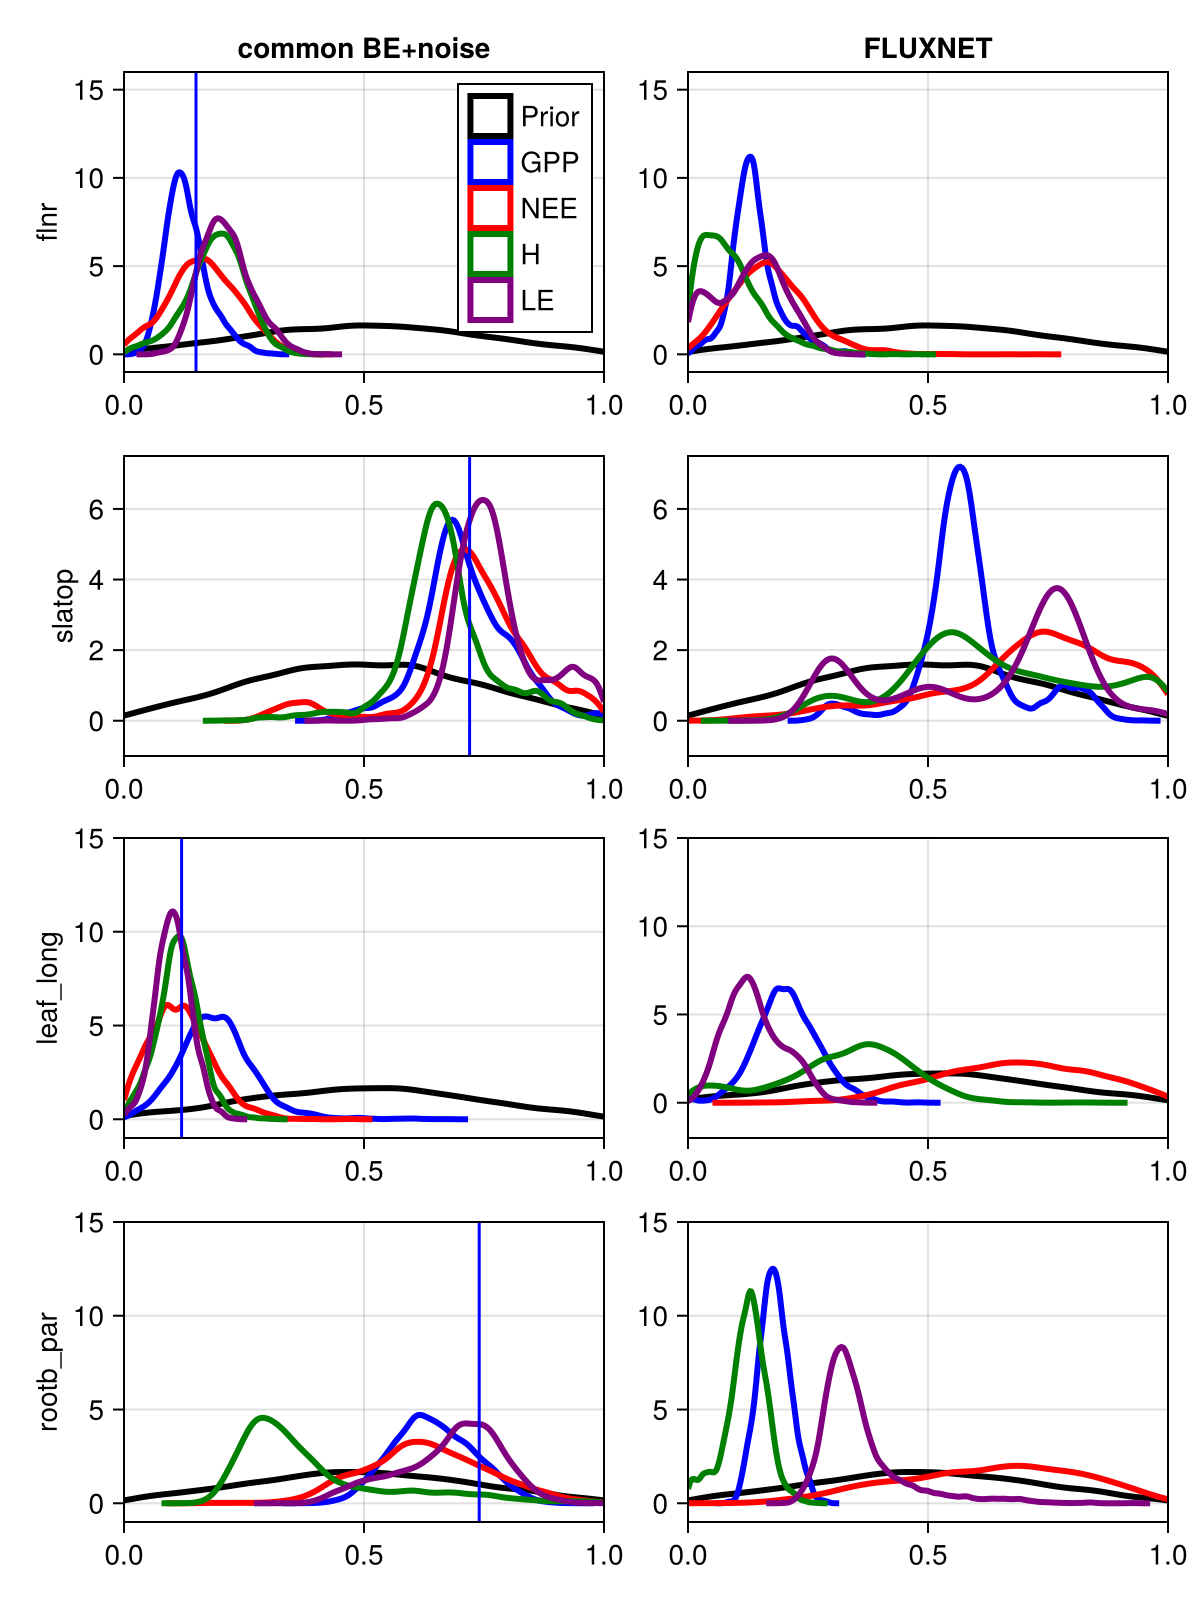

In [65]:
fig

In [68]:
save("fig8_new_GLMakie_4var_be_a_diff_iid_nobeta0_param_PDF_3_4_20260207.pdf",fig)

CairoMakie.Screen{PDF}


In [ ]:
@load "US_Me2_GPP_be_a1_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_be_a2_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_be_a3_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_be_a4_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain4
achain4=Array(chain4)

In [ ]:
achain1=Array(chain1[:,:,1])
achain2=Array(chain2[:,:,1])
achain3=Array(chain3[:,:,1])
achain4=Array(chain4[:,:,1])
println(size(achain1))

In [ ]:
plt1=corrplot(achain1[:,1:4],  axis=([], true), color=:blue, title=" ",titlefontsize=50,fillcolor=cgrad(), label=["flnr","slatop","leaf_long","rootb_par"],left_margin=3mm)

In [ ]:
plt2=corrplot(achain2[:,1:4],  axis=([], true), color=:blue, title="  ",titlefontsize=50,fillcolor=cgrad(), label=["flnr","slatop","leaf_long","rootb_par"],left_margin=3mm)

In [ ]:
plt3=corrplot(achain3[:,1:4],  axis=([], true), color=:blue,title="  ", titlefontsize=50,fillcolor=cgrad(), label=["flnr","slatop","leaf_long","rootb_par"],left_margin=3mm)

In [ ]:
plt4=corrplot(achain4[:,1:4],  axis=([], true), color=:blue, fillcolor=cgrad(),title="  ", titlefontsize=50,label=["flnr","slatop","leaf_long","rootb_par"],left_margin=5mm)

In [ ]:
plt=plot(plt1,plt2,plt3,plt4,layout=(2,2),left_margin=10mm,bottom_margin=5mm,size=(1000, 800))

savefig(plt,"figS3_pairplots_be_20250928.pdf")

### Posterior predictions / observing system simulation experiments (OSSEs)

OSSE parameter sampling from posterior distributions

In [69]:
N_samp0 = 1000

1000

In [70]:
@load "US_Me2_GPP_be_a1_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_be_a2_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_be_a3_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_be_a4_iid_nobeta0_5000_5_4par_180day_1_samebe200.jld2" chain4
achain4=Array(chain4)

25000×6 Matrix{Float64}:
 0.20579   0.792544  0.13971    0.67805   0.962178  5.82764
 0.225805  0.691687  0.138691   0.634971  0.952778  5.89234
 0.233617  0.782735  0.0855602  0.698044  0.985033  5.64558
 0.225122  0.762982  0.0487008  0.674447  1.01257   5.34728
 0.214102  0.782814  0.0817105  0.728519  0.999308  5.34035
 0.229513  0.822629  0.085226   0.741774  0.973557  5.36391
 0.166883  0.68039   0.133319   0.647598  0.988475  5.66564
 0.207237  0.822788  0.0955303  0.77856   0.99617   5.78066
 0.212108  0.728292  0.102816   0.765249  0.982817  5.66759
 0.198696  0.769983  0.097085   0.752443  1.0051    5.60575
 0.199226  0.798248  0.0953618  0.721659  0.988017  5.46202
 0.146897  0.788095  0.0917279  0.839049  1.02335   6.00552
 0.127337  0.767316  0.104539   0.862863  1.01913   5.18418
 ⋮                                                  ⋮
 0.337721  0.978734  0.0881425  0.532082  0.921206  5.54725
 0.203582  0.904561  0.189315   0.558725  0.923565  5.74437
 0.317395  0.754717  

In [71]:
p_samp1 = achain1[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp2 = achain2[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp3 = achain3[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp4 = achain4[Turing.sample(1:size(achain1,1), N_samp0),:]

1000×6 Matrix{Float64}:
 0.257087  0.806737  0.0814654  0.617208  0.976232  5.79489
 0.265604  0.706106  0.133626   0.452475  0.910938  5.73473
 0.177063  0.659704  0.0888445  0.712633  1.02611   5.71338
 0.245535  0.823674  0.0432674  0.70048   1.0128    6.64441
 0.23258   0.788393  0.156294   0.61488   0.951648  5.70121
 0.244149  0.690974  0.127169   0.685958  0.960137  5.68913
 0.352568  0.949645  0.0832927  0.481648  0.907971  6.20378
 0.306814  0.85134   0.0507234  0.627345  0.977542  6.25821
 0.2218    0.753651  0.107794   0.661365  0.989546  5.5395
 0.257817  0.747362  0.0998229  0.660507  0.979149  5.85551
 0.165183  0.759572  0.0905632  0.799358  1.02444   5.63731
 0.163662  0.738786  0.109146   0.80752   0.997052  5.50572
 0.18825   0.731536  0.068234   0.69063   1.02563   5.69896
 ⋮                                                  ⋮
 0.263422  0.711705  0.158967   0.502914  0.909761  5.65409
 0.220827  0.690639  0.0988746  0.658585  0.986929  5.59483
 0.189282  0.756355  0.

In [72]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
    err=a1*randn(length(m))
    #y = β_0.+β_1*m +err
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [73]:
function simulate_observations(N, samples, model,N_PCA)
    N_samp = size(samples,1)
    y_sim = zeros(N, N_samp)
    @threads for i = 1:N_samp
       y_sim[:,i] .= sample_observation(samples[i,:], model,N_PCA)
    end
    y_sim
end

simulate_observations (generic function with 1 method)

In [85]:
using Statistics
using Distributions

# Define the function to calculate the 95% confidence interval
function confidence_interval(data::Vector{Float64}, confidence_level::Float64=0.05)
    # Sample mean
    mean_value = mean(data)

    # Sample standard deviation
    std_dev = std(data)

    # Sample size
    n = length(data)

    # Standard error of the mean
    sem = std_dev / sqrt(n)

    # For the specified confidence interval, the critical value from the t-distribution
    # Degrees of freedom: n - 1
    df = n - 1
    alpha = 1 - confidence_level
    t_critical = quantile(TDist(df), 1 - alpha / 2)

    # Margin of error
    margin_of_error = t_critical * sem

    # Confidence interval
    lower_bound = quantile(data,0.025)
    upper_bound = quantile(data,0.975)

    return (lower_bound, upper_bound)
end

confidence_interval (generic function with 2 methods)

In [86]:
# Define a function to calculate RMSE, NRMSE, and PRMSE
function rmse(actual, predicted; method="percentage")
    n = length(actual)
    rmse_value = sqrt(sum((actual .- predicted).^2) / n)
    println("rmse_value",rmse_value)
    if method == "range"
        # Normalized by range (max - min)
        norm_rmse = rmse_value / (maximum(actual) - minimum(actual))
    elseif method == "percentage"
        # Normalized by mean (percentage RMSE)
        norm_rmse = (rmse_value / mean(actual))
    else
        error("Invalid method. Choose 'range' or 'percentage'.")
    end

    return norm_rmse
end

rmse (generic function with 1 method)

In [87]:
# Define a function to calculate RMSE, NRMSE, and PRMSE
function rmse_nee(actual, predicted; method="percentage")
    n = length(actual)
    rmse_value = sqrt(sum((actual .- predicted).^2) / n)
    println("rmse_value",rmse_value)
    if method == "range"
        # Normalized by range (max - min)
        norm_rmse = rmse_value / (maximum(actual) - minimum(actual))
    elseif method == "percentage"
        # Normalized by mean (percentage RMSE)
        norm_rmse = (rmse_value / mean(abs.(actual)))
    else
        error("Invalid method. Choose 'range' or 'percentage'.")
    end

    return norm_rmse
end

rmse_nee (generic function with 1 method)

OSSE prediction at the same site

In [90]:
ELM_Me2 = Dataset("US_Me2_GPP_g0001_g1300_2003_2007_res05.nc")
t = ELM_Me2["time"]
time1=year.(t)+dayofyear.(t)/365;

In [94]:
using CairoMakie

In [97]:
fig = Figure(size= (1000, 750));

In [102]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
   # err=σ^2*randn(length(m))
    err=a1*randn(length(m))
    #y = β_0.+β_1*m +err
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [107]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis
#l = fig[1, 1] = GridLayout()
ax1 = Axis(fig[1, 1], xlabel = "", ylabel = "GPP",title=L"\mathbf{\mathrm{GPP (gC m^{-2} d^{-1})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax1, -5, 15)
# Add shaded area
p2=band!(ax1, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
p4=lines!(ax1, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
p3=lines!(ax1, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
#p5=GLMakie.scatter!(ax1, time1[15:10:1805], GPP_01,  markersize=4,color = :green, label = "fluxnet")
rmse_value = rmse(GPP_01_be_ens, y_sim_1_1_m)
text!(ax1, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
legend=Legend(fig,[p2,p3,p4], ["95% interval","mean","best estimate"],tellheight = false, halign =:left, valign =:top, orientation = :horizontal, framevisible = false)

fig[5,2] = legend
legend.width = Relative(2.2)

fig[1,1]=ax1

rmse_value0.08008714081615055


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [108]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis
ax2 = Axis(fig[2, 1], xlabel = "", ylabel = "NEE", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax2, -5, 15)
# Add plots
p2=band!(ax2, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax2, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax2, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(GPP_01_be_ens, y_sim_1_1_m)
text!(ax2, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,1]=ax2

rmse_value0.19727146346952798


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [109]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis
ax3 = Axis(fig[3, 1], xlabel = "", ylabel = "H", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax3, -5, 15)
# Add plots
p2=band!(ax3, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax3, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax3, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(GPP_01_be_ens, y_sim_1_1_m)
text!(ax3, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,1]=ax3

rmse_value0.6865248889685271


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [110]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end
# Create figure and axis

ax4 = Axis(fig[4, 1], xlabel = "year", ylabel = "LE", title = "")
CairoMakie.ylims!(ax4, -5, 15)
# Add plots
p2=band!(ax4, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax4, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax4, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(GPP_01_be_ens, y_sim_1_1_m)
text!(ax4, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,1]=ax4

rmse_value0.16913154819548995


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [111]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_2(θ,N_PCA)
   # err=σ^2*randn(length(m))
    err=a2*randn(length(m))
    #y = β_0.+β_1*m +err
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [112]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax5 = Axis(fig[1, 2], xlabel = "", ylabel = "", title=L"\mathbf{\mathrm{NEE (gC m^{-2} d^{-1})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax5, -7, 7)
# Add plots
p2=band!(ax5, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax5, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax5, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse_nee(NEE_01_be_ens, y_sim_1_1_m)
text!(ax5, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[1,2]=ax5

rmse_value0.1289840750176913


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [113]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax6= Axis(fig[2, 2], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax6, -7, 7)
# Add plots
p2=band!(ax6, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax6, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax6, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse_nee(NEE_01_be_ens, y_sim_1_1_m)
text!(ax6, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,2]=ax6

rmse_value0.0860693105244339


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [114]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end
xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax7 = Axis(fig[3, 2], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax7, -7, 7)
# Add plots
p2=band!(ax7, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax7, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax7, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse_nee(NEE_01_be_ens, y_sim_1_1_m)
text!(ax7, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,2]=ax7

rmse_value0.2562800489080896


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [115]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end


# Create figure and axis

ax8 = Axis(fig[4, 2], xlabel = "year", ylabel = "", title = "")
CairoMakie.ylims!(ax8, -7, 7)
# Add plots
p2=band!(ax8, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax8, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax8, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse_nee(NEE_01_be_ens, y_sim_1_1_m)
text!(ax8, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,2]=ax8

rmse_value0.12821553961426077


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [116]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_3(θ,N_PCA)
   # err=σ^2*randn(length(m))
    err=a3*randn(length(m))
    #y = β_0.+β_1*m +err
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [117]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax9 = Axis(fig[1, 3], xlabel = "", ylabel = "",title=L"\mathbf{\mathrm{H (W m^{-2})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax9,  -120, 250)
# Add plots
p2=band!(ax9, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax9, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax9, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(FSH_01_be_ens, y_sim_1_1_m)
text!(ax9, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[1,3]=ax9

rmse_value1.9218184554910562


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [118]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax10 = Axis(fig[2, 3], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax10, -120, 250)
# Add plots
p2=band!(ax10, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax10, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax10, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(FSH_01_be_ens, y_sim_1_1_m)
text!(ax10, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,3]=ax10

rmse_value2.554246817104435


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [119]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax11 = Axis(fig[3, 3], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax11, -120, 250)
# Add plots
p2=band!(ax11, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax11, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax11, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(FSH_01_be_ens, y_sim_1_1_m)
text!(ax11, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,3]=ax11

rmse_value2.4244527772224718


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [120]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xticks = ([2003, 2005, 2007], ["", "", ""])

# Create figure and axis

ax12 = Axis(fig[4, 3], xlabel = "year", ylabel = "", title = "")
CairoMakie.ylims!(ax12, -120, 250)
# Add plots
p2=band!(ax12, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax12, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax12, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(FSH_01_be_ens, y_sim_1_1_m)
text!(ax12, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,3]=ax12

rmse_value2.7354297765362094


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [121]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_4(θ,N_PCA)
   # err=σ^2*randn(length(m))
    err=a4*randn(length(m))
    #y = β_0.+β_1*m +err
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [122]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax13 = Axis(fig[1, 4], xlabel = "", ylabel = "",title=L"\mathbf{\mathrm{LE (W m^{-2})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax13,-40, 180)
# Add plots
p2=band!(ax13, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax13, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax13, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(LH_01_be_ens, y_sim_1_1_m)
text!(ax13, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[1,4]=ax13

rmse_value2.7508561939199363


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [123]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax14 = Axis(fig[2, 4], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax14, -40, 180)
# Add plots
p2=band!(ax14, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax14, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax14, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(LH_01_be_ens, y_sim_1_1_m)
text!(ax14, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,4]=ax14


rmse_value2.554309725493489


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [124]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax15 = Axis(fig[3,4], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax15, -40, 180)
# Add plots
p2=band!(ax15, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax15, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax15, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(LH_01_be_ens, y_sim_1_1_m)
text!(ax15, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,4]=ax15

rmse_value4.8911620984691915


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [125]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xticks = ([2003, 2005, 2007], ["", "", ""])

# Create figure and axis

ax16 = Axis(fig[4,4], xlabel = "year", ylabel = "", title = "")
CairoMakie.ylims!(ax16, -40, 180)
# Add plots
p2=band!(ax16, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax16, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax16, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(LH_01_be_ens, y_sim_1_1_m)
text!(ax16, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,4]=ax16

rmse_value0.7483772034604452


Axis with 4 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


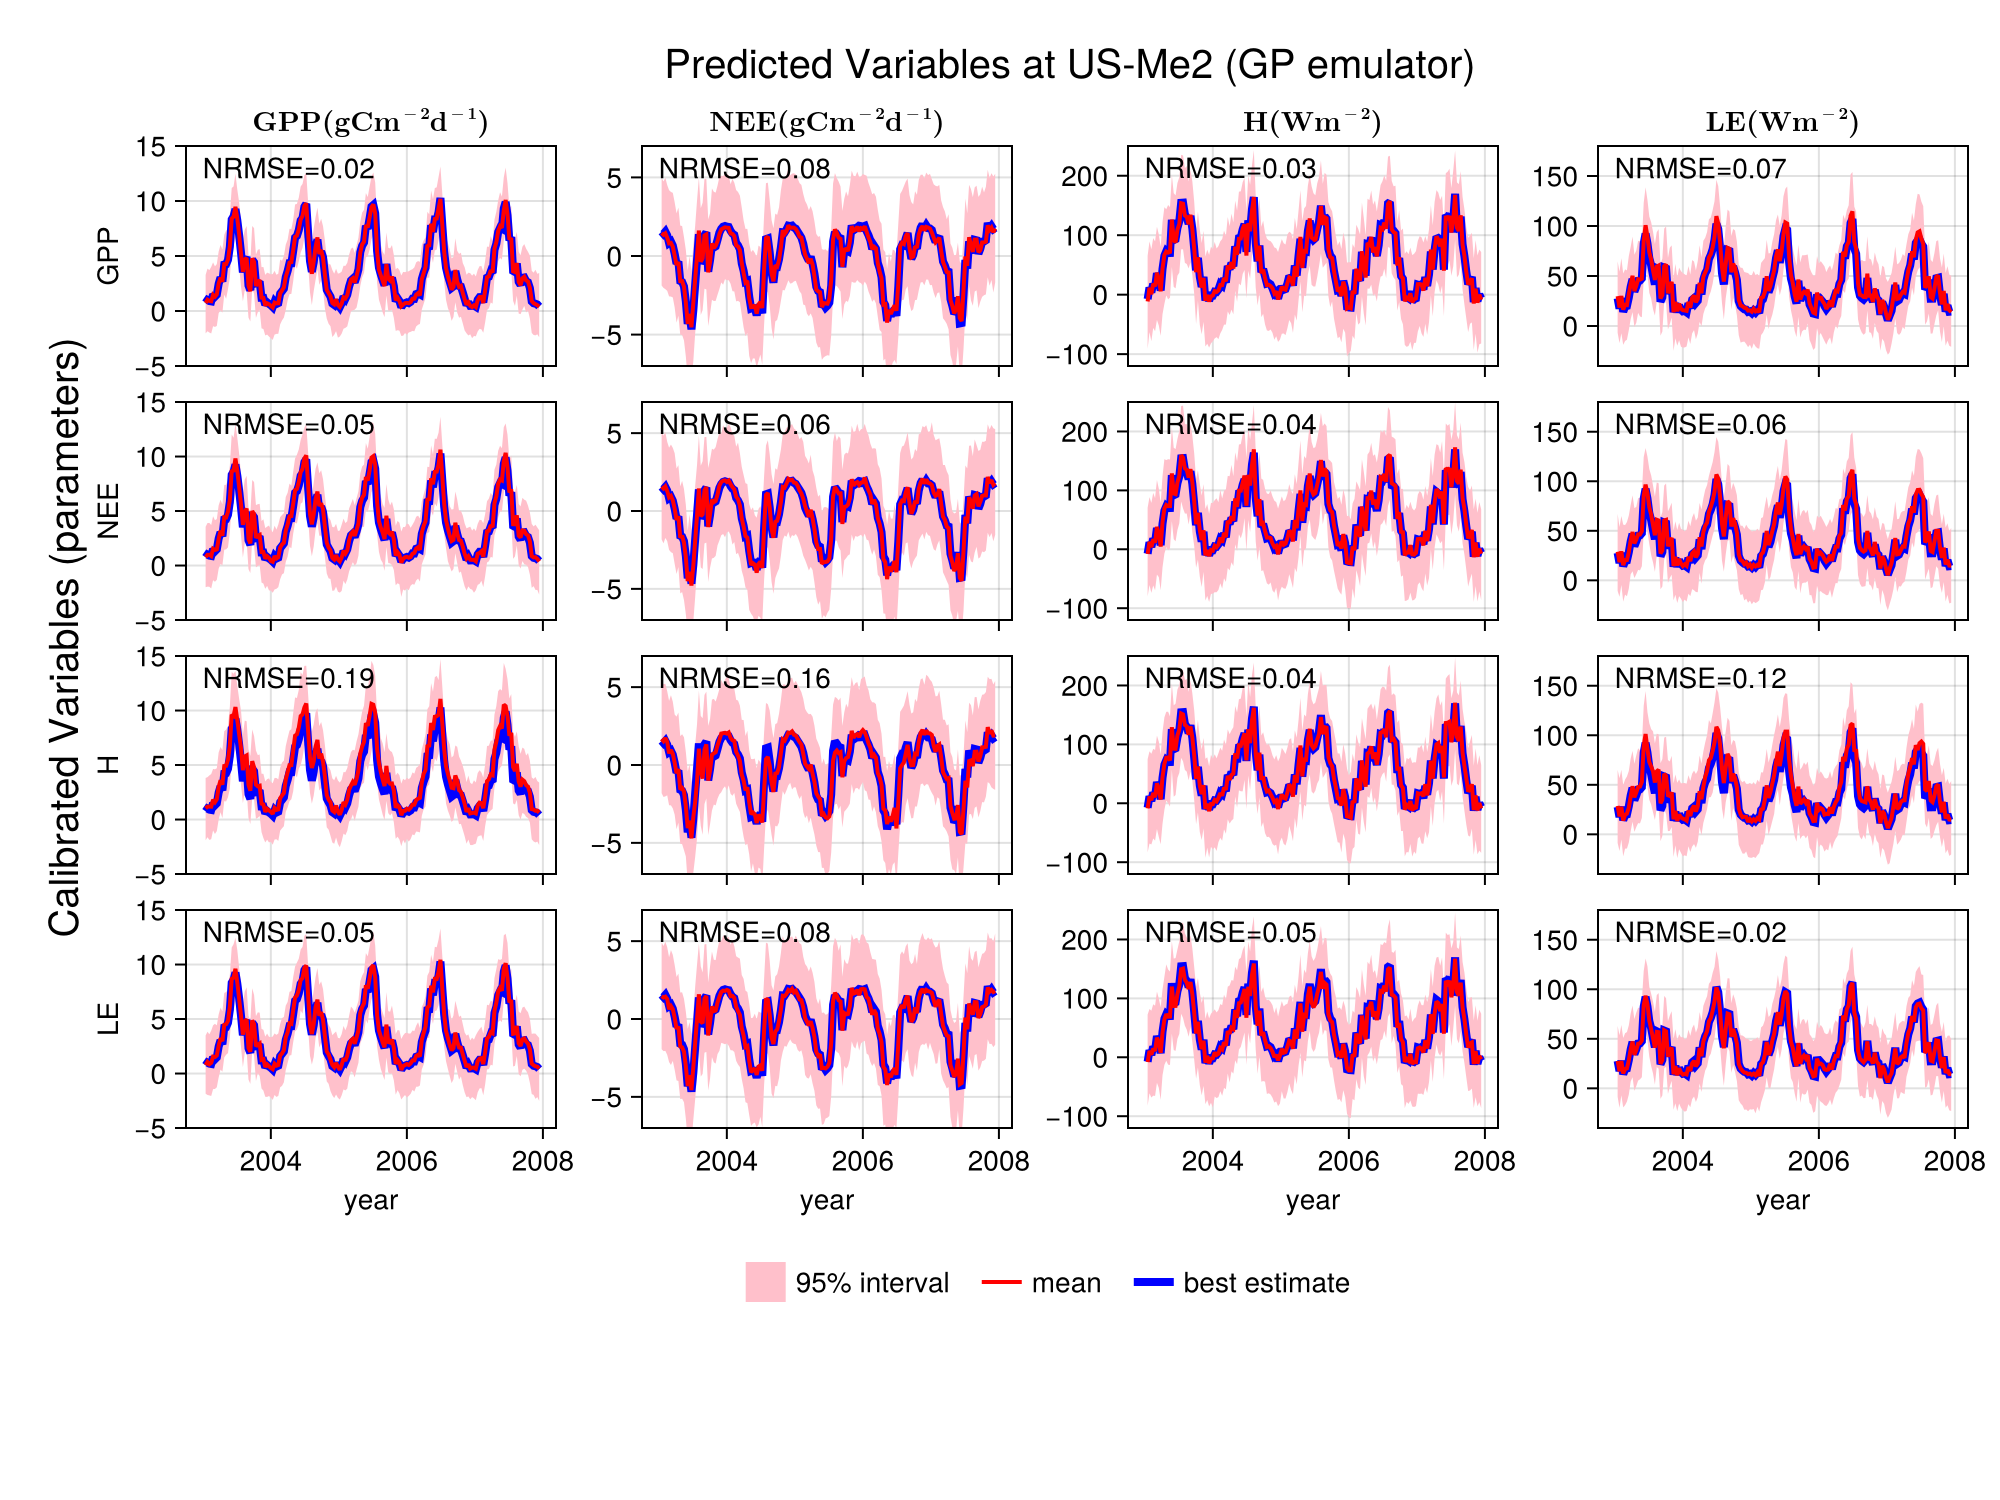

In [126]:
Label(fig[1,2:3,Top()], "Predicted Variables at US-Me2 (GP emulator)", fontsize=20, padding=(4, 4, 30, 4))
Label(fig[2:3,1,Left()], "Calibrated Variables (parameters)", rotation=π/2, fontsize=20, padding=(4, 50, 4, 4))
fig

In [127]:
save("figS6_var_4_4_1000_beiid_nobeta0_20260207.pdf",fig)

CairoMakie.Screen{PDF}
